In [1]:
import os, sys
import numpy as np
from astropy import units, constants
from astropy.io import fits
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import curve_fit
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks, gaussian
from scipy.interpolate import interp1d
from lmfit import Model, minimize
import lmfit
from lightkurve.lightcurve import LightCurve
from plasmapy.formulary.radiation import thermal_bremsstrahlung

from astropy.modeling import models
from astropy.nddata import NDUncertainty
from lmfit.models import Model

%load_ext autoreload
%autoreload 2
sys.path.append('/Users/belugawhale/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

## PROPOSAL ID 16164


def load_data(path):
    wavelength, flux, err = load_binned_data(os.path.join(path,'interp_between_1.npy'))

    times = np.load(os.path.join(path,'times.npy'))
    orbits = np.load(os.path.join(path,'orbits.npy'))

    wavelength = np.full(flux.shape, wavelength)
    return wavelength, flux, err, times, orbits

w20, f20, e20, t20, o20 = load_data(path='/Users/belugawhale/Documents/AUMic/3s')
_, _, _, t, _ = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced/')

_, flare_orbits, flare_mask = np.load('/Users/belugawhale/Documents/AUMic/flare_mask2.npy',
                                      allow_pickle=True)

parula = np.load('/Users/belugawhale/parula_colors.npy')

distance = (9.72*units.pc).to(units.cm)

In [2]:
fwc = FlaresWithCOS(wavelength=w20,
                    flux=f20,
                    flux_err=e20,
                    time=t20-t[0],
                    orbit=o20)
fwc.load_line_table(path='/Users/belugawhale/Documents/GitHub/cos_flares/')
fwc.load_lsf_model(fname='/Users/belugawhale/Documents/AUMic/aa_LSFTable_G130M_1222_LP4_cn.dat')

default_mask = fwc.measure_FUV130()

for ion in fwc.line_table['ion']:
    fwc.measure_ew(ion)

In [3]:
def multi_peaks(ttest, test):
    """
    test = time
    ttest = flux
    """

    #plt.plot(ttest, test-test.min(),'k')
    #plt.plot(ttest, test-test.min(), '.')

    p1 = np.argmax(test)
    #plt.plot(ttest[p1], test[p1], 'ro')
    
    try:
        arg = np.where((ttest.value>ttest[p1].value+100))[0]
        p2 = np.argmax(test[arg])
        #plt.plot(ttest[arg][p2], test[arg][p2], 'bo')
    except:
        arg=np.arange(0,len(ttest),1,dtype=int)
        p2=0
        
    try:
        arg3 = np.where((ttest.value>ttest[arg][p2].value+100))[0]
        p3 = np.argmax(test[arg3])
        #plt.plot(ttest[arg3][p3], test[arg3][p3], 'ko')

    except:
        arg3=np.arange(0,len(ttest),1,dtype=int)
        p3=0
        
    t0 = np.array([ttest[p1].value, ttest[arg][p2].value, ttest[arg3][p3].value])
    amp = np.array([test[p1], test[arg][p2], test[arg3][p3]])#/1e-13

    return t0, amp

In [4]:
_, which_o, f_int = np.load('/Users/belugawhale/Documents/AUMic/flare_mask2.npy',
                            allow_pickle=True)

In [6]:
%load_ext autoreload
%autoreload 2
sys.path.append('/Users/belugawhale/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


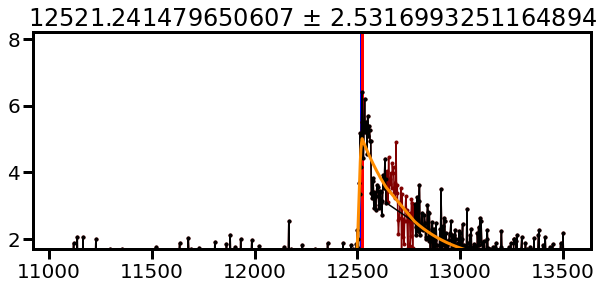

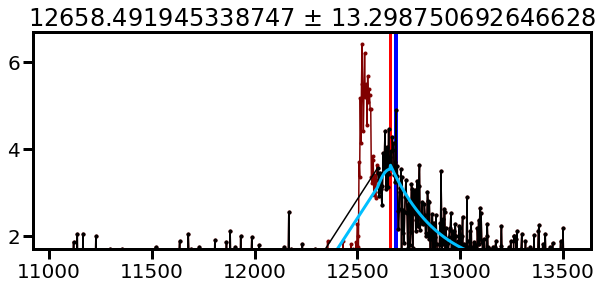

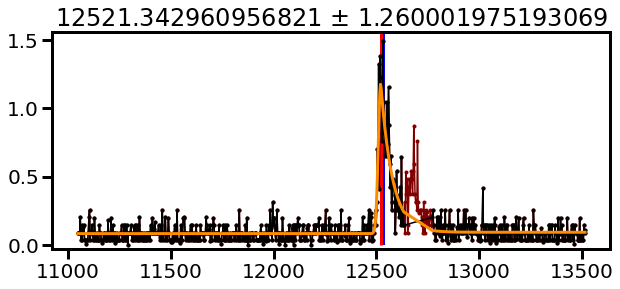

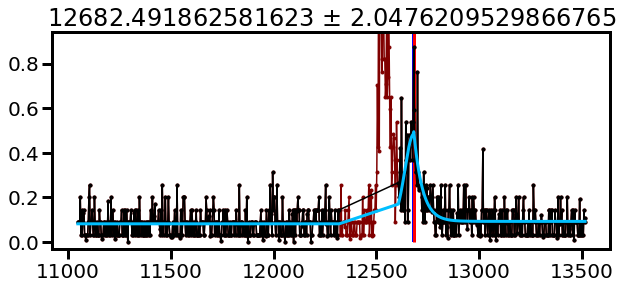

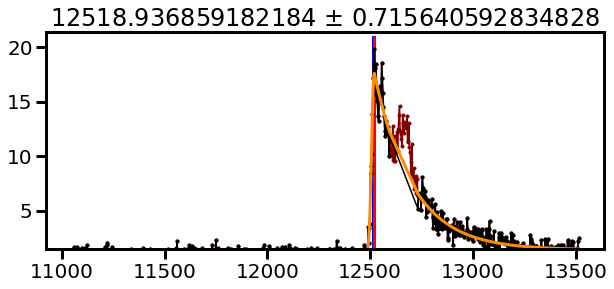

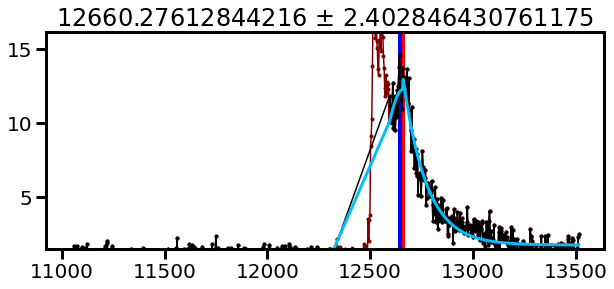

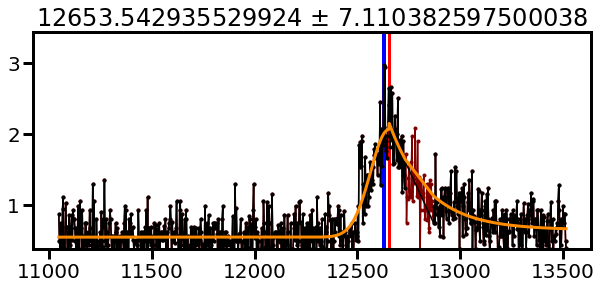

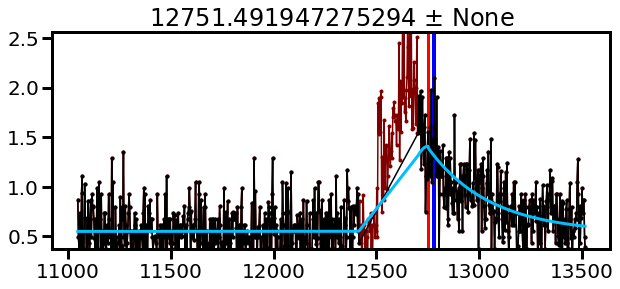

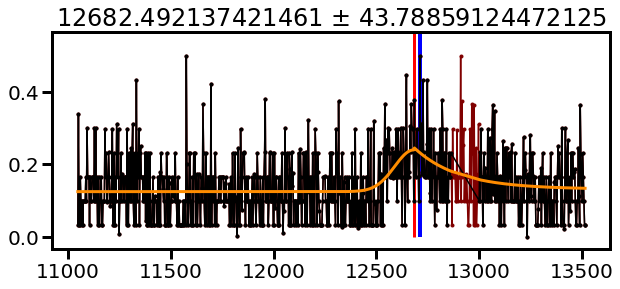

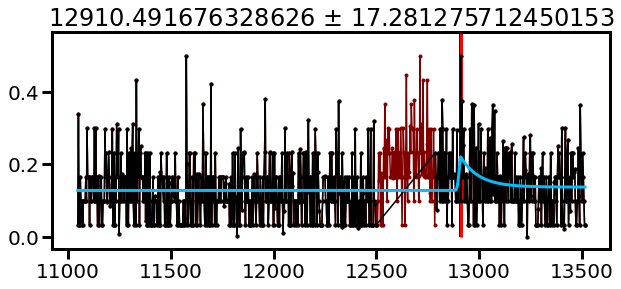

In [7]:
ions = ['CII_11', 'SiIII', 'CIII','NV_1','FeXXI']

t0 = np.array([1486., 1601., 1755.])
outputs = np.zeros((2,len(ions)))
outputs_errs = np.zeros((2,len(ions)))


for j,i in enumerate(ions):

    x = fwc.time.value + 0.0
    y = fwc.width_table[i]/1e-11
    y -= np.nanmin(y)
    

    t0, amp = multi_peaks(fwc.time, fwc.width_table[i])
    rise, decay = [5,5,5],[50,50,50] 
    
    model = 'white light'
    
    if i == 'CII_11' or i == 'SiIII' or i == 'NV_1' or i == 'CIII':
        args = 2
    else:
        args=1
    
        
    for t in range(2):
        plt.figure(figsize=(10,4))
        mask = np.ones(len(x), dtype=bool)
        plt.plot(x, y, 'maroon', marker='.')
        plt.vlines(t0[t], 0,21, 'b', lw=4)
        if t == 0:
            argwhere = np.where(x >= t0[1])[0][0]
            mask[np.arange(argwhere-15, argwhere+30, 1, dtype=int)] = False
            #model = 'white light'
        else:
            argwhere = np.where(x >= t0[0])[0][0]
            mask[np.arange(argwhere-70, argwhere+25, 1, dtype=int)] = False
            #model = 'skewed gaussian'
        model = 'white light'
            
        out = fwc.fit_flare(ion=i, mask=mask, model=model,
                            eta=t0[t:t+1], 
                            omega=np.full(1, 100),
                            alpha=np.full(1, 180),
                            offset=np.zeros(1),
                            amp=amp[t:t+1]/1e-11*100,
                            t0=t0[t:t+1], 
                            rise=rise[t:t+1], decay=decay[t:t+1],
                            x=x[mask], 
                            y=y[mask])
        
        plt.plot(x[mask], y[mask], 'k', marker='.')
        if t == 0:
            c='darkorange'
            plt.title('{} $\pm$ {}'.format(out[-1].params['f00_t0'].value,
                                       out[-1].params['f00_t0'].stderr))
        else:
            c='deepskyblue'
            plt.title('{} $\pm$ {}'.format(out[-1].params['f00_t0'].value,
                                       out[-1].params['f00_t0'].stderr))
        plt.plot(x[mask], out[-1].best_fit, color=c, lw=3)
        plt.vlines(out[-1].params['f00_t0'].value, 0, 21, 'r', lw=3)
        
        try:
            outputs[t][j] = out[-1].params['f00_t0'].value + 0.0
            outputs_errs[t][j] = out[-1].params['f00_t0'].stderr + 0.0
            if outputs_errs[t][j] < 3:
                outputs_errs[t][j] += 3
        except:
            pass

        plt.ylim(np.nanmin(fwc.width_table[i][mask]/1e-11),
                 np.nanmax(fwc.width_table[i][mask]/1e-11)+0.1)

        plt.show()

In [8]:
def gaussian(x, mu, std, f, s):#, lsf):
    """ A gaussian model. """
    exp = -0.5 * (x-mu)**2 / std**2
    denom = std * np.sqrt(np.pi * 2.0)
    g = f / denom * np.exp(exp)
    return g + s

def polynomial(x, a, b, c, t0, scale, offset):
    y = a*(x-t0)**2 + b*x + c
    return y/scale + offset

In [28]:
COLOR = 'w'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_70115/3352877820.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(os.path.join(path,'time_offset.png'), transparent=True,


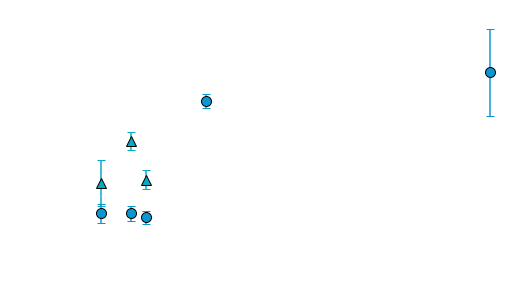

In [29]:
logT = np.array([4.5, 4.7, 4.8, 5.2, 7.1])
d = .02

fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(7.5,4))

ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax2.spines['top'].set_visible(False)

if COLOR == 'k':
    cstart = 0
    path = '/Users/belugawhale/Documents/GitHub/presentation-figures/aumic-flares/light-bkg/'
else:
    cstart = 80
    path = '/Users/belugawhale/Documents/GitHub/presentation-figures/aumic-flares/dark-bkg/'

for i in range(len(ions)):

    for j in range(2):

        if j == 0:
            start = 12531
            marker='o'
            linestyle='-'
            c=parula[cstart]
        else:
            start = 12531+120
            marker='^'
            linestyle='--'
            c=parula[cstart+20]
            
        y = outputs[j][i]-start 
        
        if y > 100:
            ax = ax1
            kwargs = dict(transform=ax.transAxes, color=COLOR, clip_on=False)
            ax.plot((-d,+d), (-d,+d), **kwargs)
            ax.plot((1-d,1+d),(-d,+d), **kwargs)
            if y < 120:
                ax.errorbar(0,0, 1,
                            marker='o', linestyle='', ms=12, lw=1.5,
                            markeredgecolor='k',
                            color=parula[cstart], capsize=4, label='Primary Peak')
                ax.errorbar(0,0, 1,
                            marker='^', linestyle='', ms=12, lw=1.5,
                            markeredgecolor='k',
                            color=parula[cstart+20], capsize=4, label='Secondary Peak')
            
        else:
            ax = ax2
            kwargs = dict(transform=ax.transAxes, color=COLOR, clip_on=False)
            ax.plot((-d,+d), (1-d,1+d), **kwargs)
            ax.plot((1-d,1+d),(1-d,1+d), **kwargs)
            
        
        if outputs_errs[j][i] != 0:
            ax.errorbar(logT[i],
                        outputs[j][i]-start,
                        yerr=outputs_errs[j][i], ms=10,
                        marker=marker, linestyle=linestyle, lw=1.5,
                        color=c, capsize=4, markeredgecolor='k')
            
#lgnd = ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=2, mode="expand", borderaxespad=0., title='Flare B')

ax2.hlines(0, 0, 10, linestyle='--', color=COLOR, lw=1)

ax1.set_xlim(4.4, 7.2)
ax2.set_xlim(4.4, 7.2)
ax1.set_ylim(104,210)
ax2.set_ylim(-20,40)
ax1.set_yticks(np.linspace(120,210,3,dtype=int))
ax2.set_yticks(np.linspace(-15,30,3,dtype=int))
ax1.set_xticklabels([])
ax2.set_ylabel('Time Offset [s]', y=1.012)
ax2.set_xlabel('log$_{10}$(T$_{form}$ [K])')
plt.subplots_adjust(hspace=0.06)
plt.savefig(os.path.join(path,'time_offset.png'), transparent=True,
            dpi=300, rasterize=True, bbox_inches='tight')